# STEP 1 : 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
* 결측치 처리
* 로그 변환

결측치 처리를 하기전 시계열이 준비되었으므로 시각화를 통해 안정성(Stationarity) 여부를 확인해 보겠습니다.

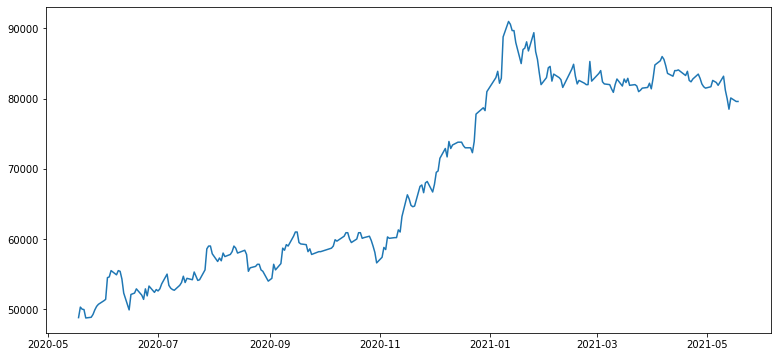

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [3]:
# 결측치 여부 확인
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

* ### 결측치 처리 (결측치 처리 방법 2가지)
1. 결측치가 있는 데이터를 모두 삭제(drop)

2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

In [4]:
# 결측치 처리 (보간방식 보간 기준은 time 선택)
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

* ###  로그 변환

시간 추이에 따라 분산이 점점 커지고 있다는 점입니다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됩니다.

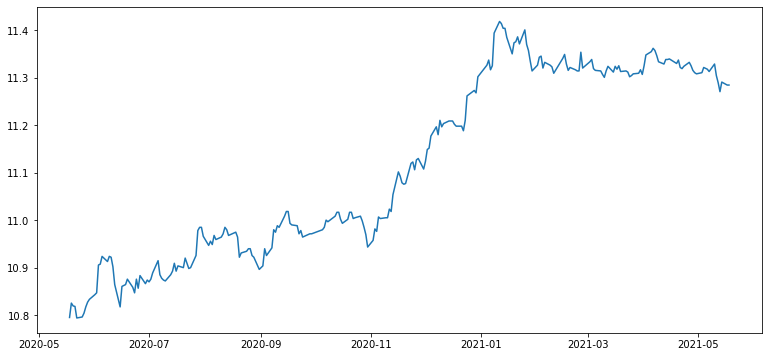

In [5]:
# 로그변환

ts_log = np.log(ts)

# 로그변환 확인
plt.plot(ts_log)
plt.show()

p-value가 0.59로 기존보다 0.07 줄어들었습니다. 시간 추이에 따른 분산이 조금 더 일정해 진것을 확인할 수 있습니다. 아주 효과적인 변환은 아니였지만 가장 큰 문제점은 

# STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test(ADF Test)
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

### 귀무 가설이란?
귀무 가설은 통계학에서 처음부터 버릴 것을 예상하는 가설이다. 차이가 없거나 의미있는 차이가 없는 경우의 가설이며 이것이 맞거나 맞지 않다는 통계학적 증거를 통해 증명하려는 가설입니다.
예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 귀무 가설은 “전국 남학생의 평균 키는 170cm과 같다.(또는 차이가 없다.)”가 될 것입니다. 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 귀무가설은 “개발한 백신은 효과가 없다.(또는 차이가 없다).” 가 됩니다. 즉 귀무가설은 “~와 차이가 없다.” “~의 효과가 없다.” “~와 같다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.
### 대립 가설이란?
대립가설의 정의는 “귀무가설이 거짓이라면 대안적으로 참이 되는 가설" 입니다. 쉽게 설명하면 “귀무가설이 틀렸다고 판단했을 때(기각되었을 때), 대안적으로 선택하는(채택되는) 가설"을 말합니다. 
예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 대립 가설은 “전국 남학생의 평균 키는 170cm와 다르다.(또는 차이가 있다.)”가 될 것이고, 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 대립가설은 “개발한 백신은 효과가 있다.(또는 차이가 있다).” 가 됩니다. 즉 대립가설은 “~와 차이가 있다.” “~의 효과는 있다.” “~와 다르다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.
### p-value란?
p-value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 하다. 이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [7]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다. 

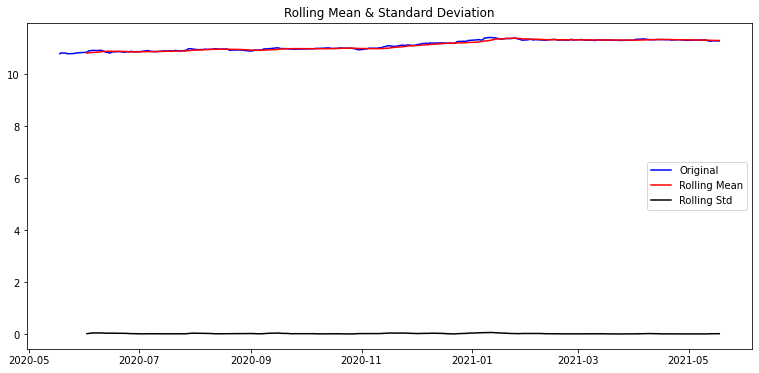

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


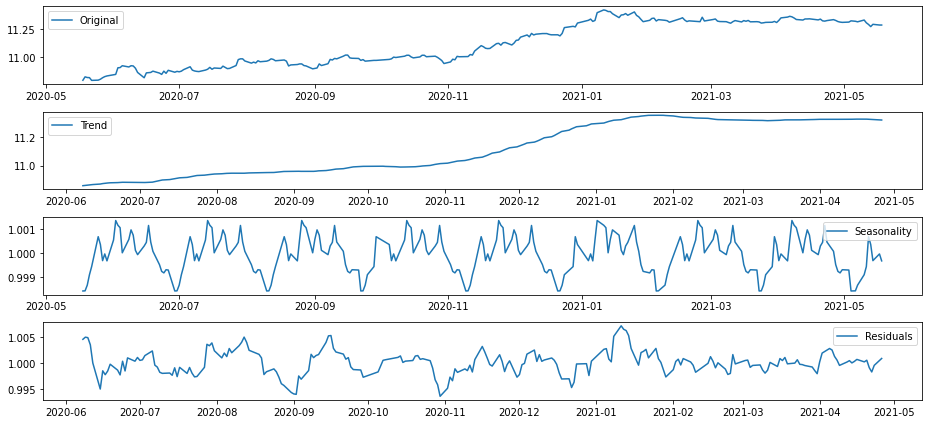

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

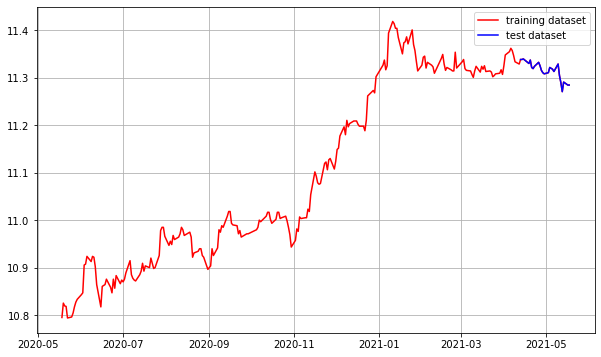

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# STEP 5 : 적정 ARIMA(Autoregressive Integrated Moving Average) 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기


ARIMA의 모수는 아래의 3가지가 있습니다

* p : 자기회귀 모형(AR)의 시차
* d : 차분 누적(I) 횟수
* q : 이동평균 모형(MA)의 시차  

이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

'오늘은 주식이 올라서 균형을 맞추겠지?'라는 AR 형태의 기대와
'어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 MA 형태의 우려
ARIMA는 두 모델 사이에서 적정 수준을 찾아가는 능력을 보여 줍니다.

### ACF
* 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
* 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함.
* ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

### PACF
* 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
* k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


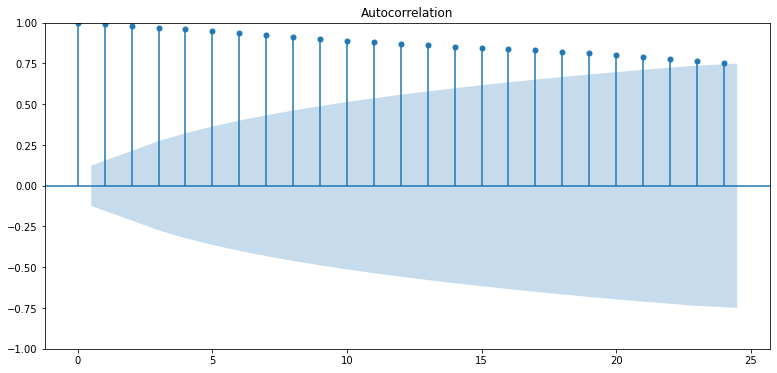

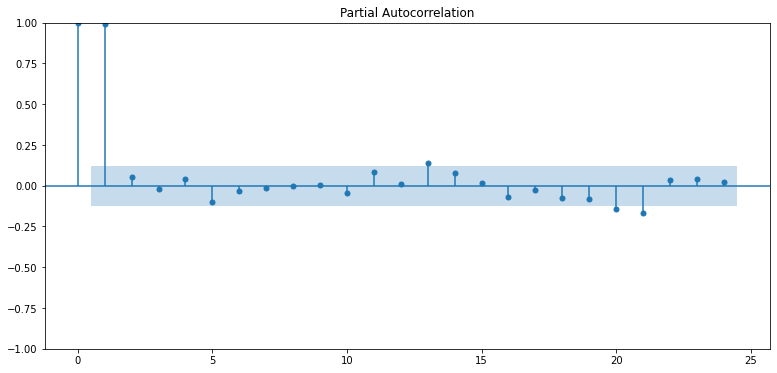

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


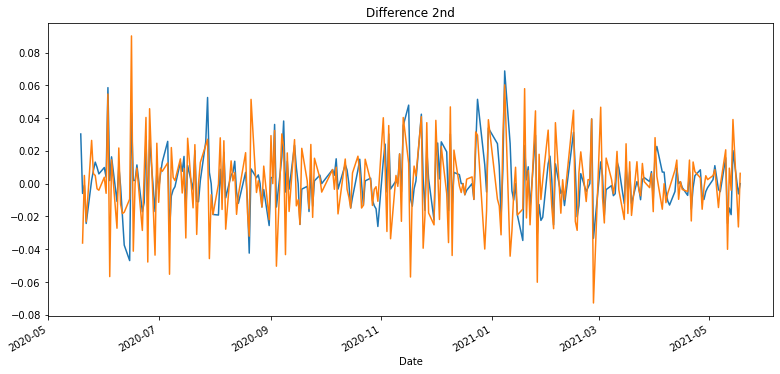

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


# STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        06:09:34   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


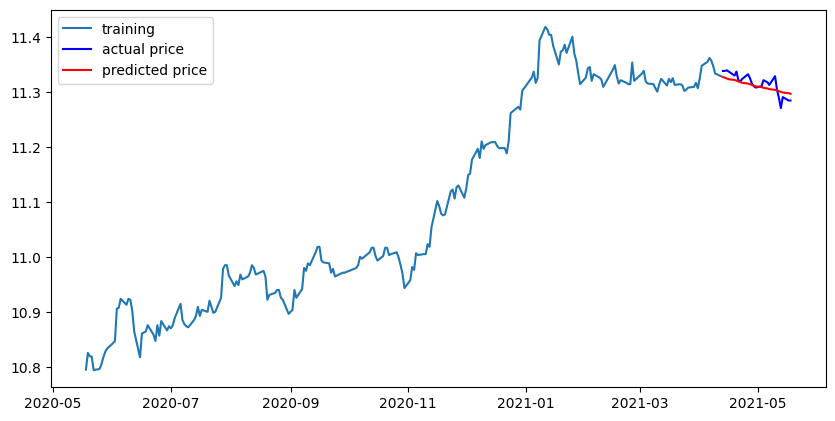

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# STEP 7 : 다른 주식 종목 예측해 보기

## BTC-USD

In [15]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    52149.007813
2021-02-18    51679.796875
2021-02-19    55888.132813
2021-02-20    56099.519531
2021-02-21    57539.945313
Name: Close, dtype: float64

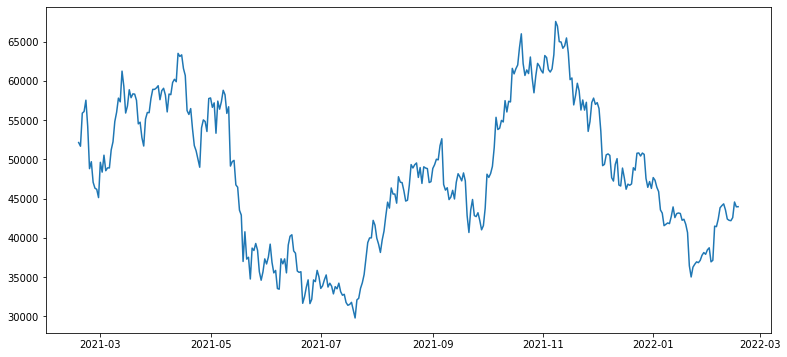

In [16]:
plt.plot(ts)

In [17]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [18]:
# 로그 변환 시도 
ts_log = np.log(ts)

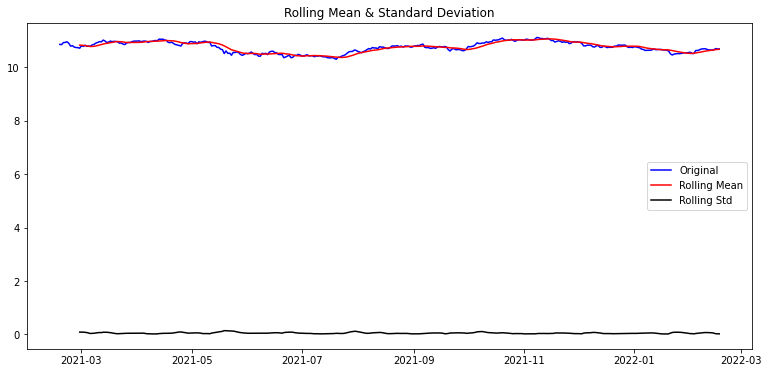

Results of Dickey-Fuller Test:
Test Statistic                  -1.895364
p-value                          0.334245
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


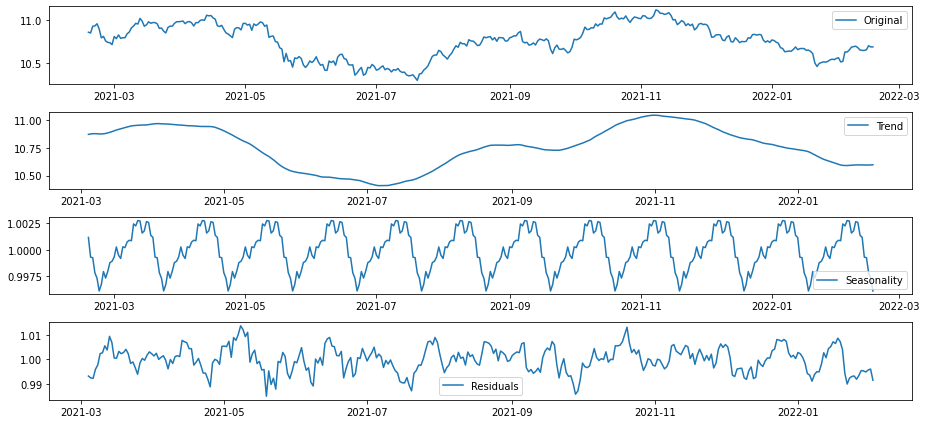

In [19]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [20]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.105923e+00
p-value                        9.585574e-08
#Lags Used                     9.000000e+00
Number of Observations Used    3.260000e+02
Critical Value (1%)           -3.450569e+00
Critical Value (5%)           -2.870447e+00
Critical Value (10%)          -2.571515e+00
dtype: float64


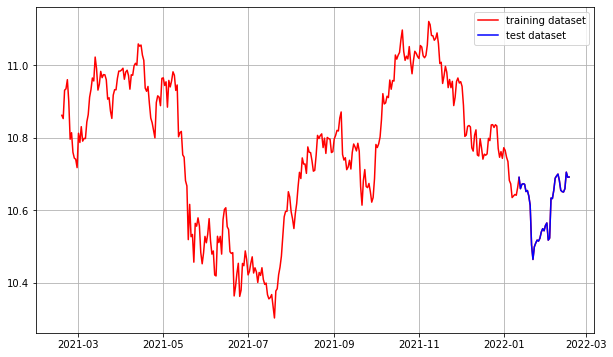

In [21]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


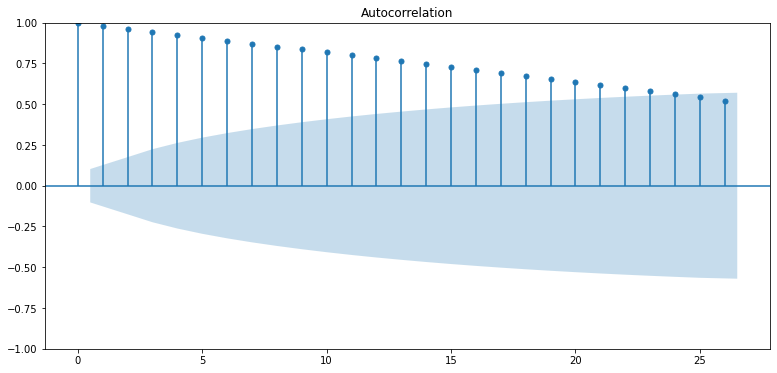

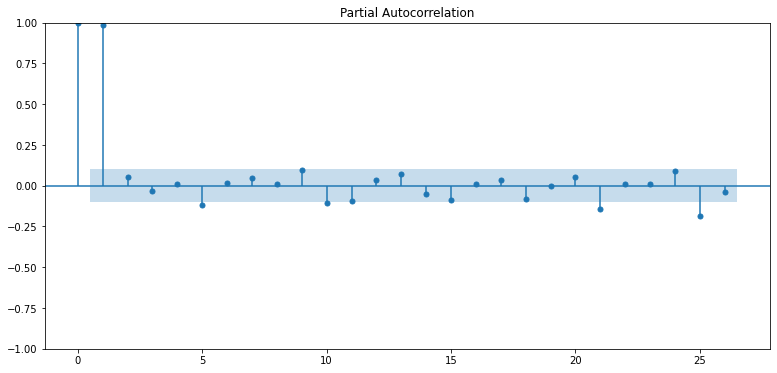

In [22]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.104400
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


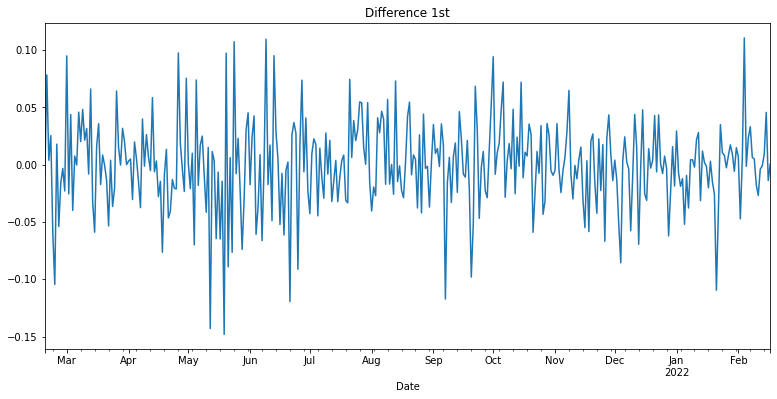

In [23]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.144221e+00
p-value                        2.796108e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


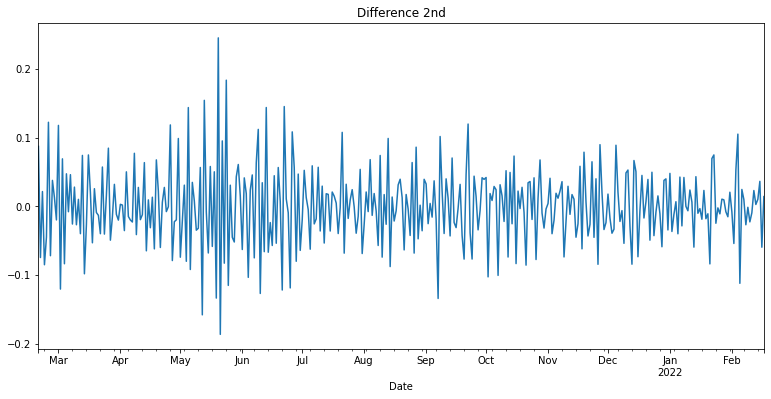

In [24]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [25]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                ARIMA(14, 1, 0)   Log Likelihood                 605.948
Date:                Thu, 17 Feb 2022   AIC                          -1181.897
Time:                        06:09:39   BIC                          -1125.001
Sample:                    02-17-2021   HQIC                         -1159.197
                         - 01-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0668      0.062     -1.080      0.280      -0.188       0.054
ar.L2          0.0426      0.056      0.758      0.449      -0.068       0.153
ar.L3         -0.0178      0.059     -0.301      0.7

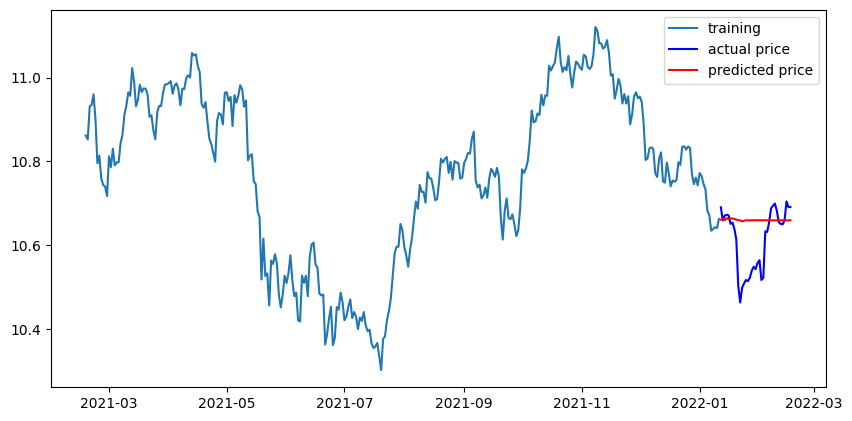

In [26]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12121047.759682769
MAE:  2594.3351672899594
RMSE:  3481.5295144063866
MAPE: 6.81%


## 회고



P 0, D 1, Q 14 
MAPE: 6.88%  
P 1, D 1, Q 14 
MAPE: 6.94%  


P 2, D 1, Q 0    
P 0, D 1, Q 2  
MAPE: 6.88%  
P 1, D 1, Q 0  
P 0, D 1, Q 1  
MAPE: 6.87%  

P 0, D 0, Q 2  
MAPE: 17.87% 

P 14, D 1, Q 1  
MAPE: 6.86% 

#### P 14, D 1, Q 0   
MAPE: 6.81%  

* 차분값d를 0으로두니 과차분되어 안정성이 더욱 떨어진 모습이 보였으며 2는 조금 부족한 안정성이 보이며 1이 대부분 가장 안정성이 높은것으로 보여진다.

* 회고에 적은값 이외에도 모수값을 많이 수정하였을때 p, d, q,값은 14,1,0 이 실험 해본것 중에서는 가장 좋은 결과를 보여주었다.

* 최종예측모델 결과값이 썩 만족스럽지 못한것은 BTC 그래프를 보면 변동자체가 너무 심해 예측하는것이 어려운거같다. 그렇지만 더 적당한 모수를 찾는다면 조금은 더 좋은 모델이 될 수 있겠지만 큰 차이는 없을꺼 같다.

* LMS에도 적혀 있었지만 이번노드가 특히 통계학적인 공부가 많이 필요하단걸 새삼 느끼게 되는 공부였다. 여러 통계식과 용어가 너무 어려워 한번 전체적으로 통계공부를 간단하게 라도 할 필요가 있음을 느꼈다. 